In [3]:
from pathlib import Path
import pandas as pd

# Search recursively in the specified external directory for CSV files starting with '01'
data_root = Path(r"D:\LegoVR\unity-lego-vr\Other_than_in_project_files\ET_Data")
if not data_root.exists():
    raise FileNotFoundError(f"Data directory not found: {data_root}")

matching_csvs = sorted(
    [p for p in data_root.rglob("*.csv") if p.name.startswith("01")]
)

if not matching_csvs:
    raise FileNotFoundError("No CSV files starting with '01' were found in the specified directory.")

csv_path = matching_csvs[0]
print(f"Loading CSV: {csv_path}")

df = pd.read_csv(csv_path)
print(f"Loaded shape: {df.shape}")
df.head()


Loading CSV: D:\LegoVR\unity-lego-vr\Other_than_in_project_files\ET_Data\01_ET_Data_2025-08-08.csv
Loaded shape: (472291, 50)


,gaze_capture_time,raw_timestamp,relative_to_unix_epoch_timestamp,focus_distance,frame_number,stability,status,gaze_forward_x,gaze_forward_y,gaze_forward_z,...,hmd_rotation_y,hmd_rotation_z,hmd_rotation_w,model_name,is_building_model,hit_obj_name,calibration_state,calibration_attempts,left_eye_calibration_quality,right_eye_calibration_quality
0,1000002773811334400,1754658861466,5.185122,0.913979,257894,0.0,Valid,0.199822,-0.038434,0.979078,...,0.859162,-0.197105,0.457304,NaN,False,Floor,WaitingForUser,0,Unknown,Unknown
1,1000002773816336100,1754658861467,5.185122,0.908018,257895,0.0,Valid,0.227848,-0.056482,0.972057,...,0.859162,-0.197105,0.457304,NaN,False,Floor,WaitingForUser,0,Unknown,Unknown
2,1000002773821337800,1754658861467,5.185122,0.915157,257896,0.0,Valid,0.254252,-0.073261,0.964359,...,0.859162,-0.197105,0.457304,NaN,False,Floor,WaitingForUser,0,Unknown,Unknown
3,1000002773826339500,1754658861467,5.185122,0.965864,257897,0.0,Valid,0.278826,-0.091104,0.956010,...,0.859162,-0.197105,0.457304,NaN,False,Floor,WaitingForUser,0,Unknown,Unknown
4,1000002773831339600,1754658861467,5.185122,1.029571,257898,0.0,Valid,0.302282,-0.109190,0.946944,...,0.859162,-0.197105,0.457304,NaN,False,Floor,WaitingForUser,0,Unknown,Unknown


In [8]:
df.columns

Index(['gaze_capture_time', 'raw_timestamp',
       'relative_to_unix_epoch_timestamp', 'focus_distance', 'frame_number',
       'stability', 'status', 'gaze_forward_x', 'gaze_forward_y',
       'gaze_forward_z', 'gaze_origin_x', 'gaze_origin_y', 'gaze_origin_z',
       'left_forward_x', 'left_forward_y', 'left_forward_z', 'left_origin_x',
       'left_origin_y', 'left_origin_z', 'left_status', 'left_pupil_diameter',
       'left_iris_diameter', 'left_pupil_iris_ratio', 'left_eye_openness',
       'right_forward_x', 'right_forward_y', 'right_forward_z',
       'right_origin_x', 'right_origin_y', 'right_origin_z', 'right_status',
       'right_pupil_diameter', 'right_iris_diameter', 'right_pupil_iris_ratio',
       'right_eye_openness', 'inter_pupillary_distance', 'hmd_position_x',
       'hmd_position_y', 'hmd_position_z', 'hmd_rotation_x', 'hmd_rotation_y',
       'hmd_rotation_z', 'hmd_rotation_w', 'model_name', 'is_building_model',
       'hit_obj_name', 'calibration_state', 'calibr

Plotting 355937 samples where 'is_building_model' is True.
Using columns: time='time_ms', left='left_pupil_diameter', right='right_pupil_diameter'


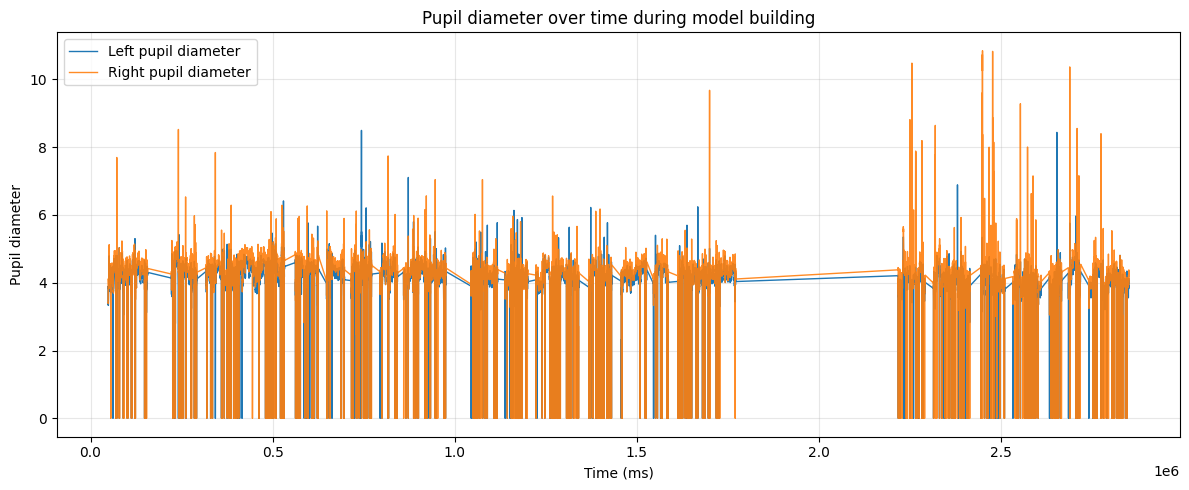

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert Varjo gaze capture time to milliseconds (relative, starting at 0)
def _to_milliseconds(series: pd.Series) -> pd.Series:
    # Datetime-like
    if np.issubdtype(series.dtype, np.datetime64):
        t0 = series.iloc[0]
        return (series - t0).dt.total_seconds() * 1000.0

    # Try numeric
    s = pd.to_numeric(series, errors='coerce')
    if s.isna().all():
        # Try parse datetime strings
        parsed = pd.to_datetime(series, errors='coerce', utc=True)
        if parsed.isna().all():
            raise ValueError("gaze_capture_time could not be parsed as numeric or datetime.")
        t0 = parsed.iloc[0]
        return (parsed - t0).dt.total_seconds() * 1000.0

    # Detect units using median difference between consecutive samples
    diffs = s.diff().dropna().abs()
    median_diff = float(diffs.median()) if not diffs.empty else float(s.iloc[-1] - s.iloc[0])

    # Heuristics:
    # - nanoseconds: ~8_000_000 per 8 ms sample at 120 Hz → >1e6
    # - microseconds: ~8_000 per 8 ms sample → >1e3
    # - milliseconds: ~8 per 8 ms sample → >0.5
    # - seconds: ~0.008 per 8 ms sample → else
    if median_diff > 1e6:      # ns → ms
        ms = s / 1e6
    elif median_diff > 1e3:    # µs → ms
        ms = s / 1e3
    elif median_diff > 0.5:    # already ms
        ms = s
    else:                      # seconds → ms
        ms = s * 1e3

    return ms - ms.min()

# Normalize boolean-like columns

def _to_bool(series: pd.Series) -> pd.Series:
    if series.dtype == bool:
        return series
    if np.issubdtype(series.dtype, np.number):
        return series.astype(float) != 0.0
    lower = series.astype(str).str.strip().str.lower()
    return lower.isin(["true", "1", "yes", "y", "t"])

# Ensure required columns exist
_time_col = "gaze_capture_time"
if _time_col not in df.columns:
    raise KeyError(f"Column '{_time_col}' not found in data. Available columns include: {list(df.columns)[:20]} ...")

# Create time in ms (relative to first sample)
df["time_ms"] = _to_milliseconds(df[_time_col])

# Try to locate left/right pupil diameter columns robustly

def _find_pupil_col(side_keywords):
    for c in df.columns:
        l = c.lower()
        if "pupil" in l and "diam" in l and any(k in l for k in side_keywords):
            return c
    return None

_left_col = _find_pupil_col(["left", "_l", " left", "left_eye"]) or ("left_pupil_diameter" if "left_pupil_diameter" in df.columns else None)
_right_col = _find_pupil_col(["right", "_r", " right", "right_eye"]) or ("right_pupil_diameter" if "right_pupil_diameter" in df.columns else None)

if _left_col is None or _right_col is None:
    raise KeyError("Could not find left/right pupil diameter columns (looked for names containing 'pupil' + 'diam' + side).")

# Filter rows where is_building_model is True
_cond_col = "is_building_model"
if _cond_col not in df.columns:
    raise KeyError(f"Column '{_cond_col}' not found in data.")

_mask = _to_bool(df[_cond_col])
df_plot = df.loc[_mask, ["time_ms", _left_col, _right_col]].dropna()

print(f"Plotting {len(df_plot)} samples where '{_cond_col}' is True.")
print(f"Using columns: time='time_ms', left='{_left_col}', right='{_right_col}'")

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(df_plot["time_ms"], df_plot[_left_col], label="Left pupil diameter", color="#1f77b4", linewidth=1)
plt.plot(df_plot["time_ms"], df_plot[_right_col], label="Right pupil diameter", color="#ff7f0e", linewidth=1, alpha=0.9)
plt.xlabel("Time (ms)")
plt.ylabel("Pupil diameter")
plt.title("Pupil diameter over time during model building")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


First model in dataset: 'C3M2A'
Found 20000 samples for first model 'C3M2A' where is_building_model is True


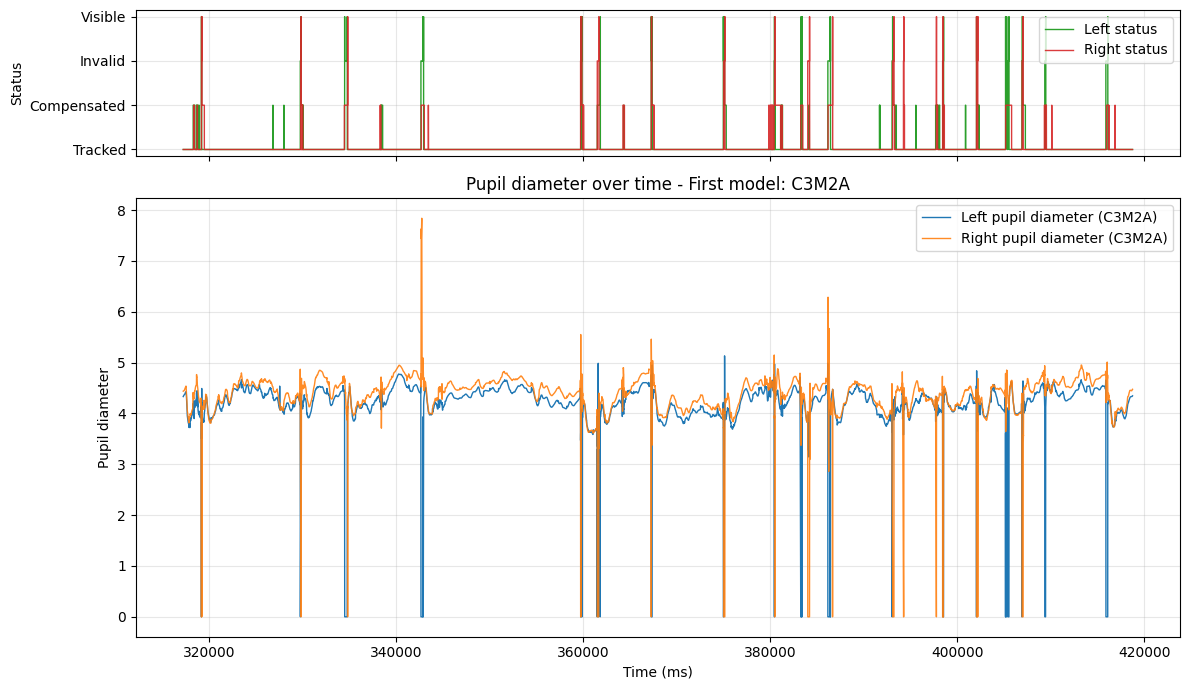


Statistics for first model 'C3M2A':
Left pupil diameter - Mean: 4.19, Std: 0.51
Right pupil diameter - Mean: 4.37, Std: 0.45
Time range: 317271.9 - 418730.6 ms


In [22]:
# Check if model_name column exists
if 'model_name' not in df.columns:
    raise KeyError("Column 'model_name' not found in data.")

# Get the first model name (first non-null value)
first_model = df['model_name'].dropna().unique()[1]
print(f"First model in dataset: '{first_model}'")

# Ensure status columns exist
if 'left_status' not in df.columns or 'right_status' not in df.columns:
    raise KeyError("Columns 'left_status' and/or 'right_status' not found in data.")

# Filter for the first model AND is_building_model is True
mask_first_model = (df['model_name'] == first_model) & _to_bool(df['is_building_model'])
df_first_model = df.loc[mask_first_model, ["time_ms", _left_col, _right_col, "left_status", "right_status"]].copy().head(20000)

# Drop NaNs only from time/pupil columns to keep statuses visible
df_first_model = df_first_model.dropna(subset=["time_ms", _left_col, _right_col])

print(f"Found {len(df_first_model)} samples for first model '{first_model}' where is_building_model is True")

# Visualize status (top) and pupil diameter (bottom)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

# Top: per-eye status as step plots
ax0.step(df_first_model["time_ms"], df_first_model["left_status"], where="post", label="Left status", color="#2ca02c", linewidth=1)
ax0.step(df_first_model["time_ms"], df_first_model["right_status"], where="post", label="Right status", color="#d62728", linewidth=1, alpha=0.9)
ax0.set_ylabel("Status")
try:
    _uniq = sorted(pd.unique(pd.concat([df_first_model["left_status"], df_first_model["right_status"]]).dropna()))
    ax0.set_yticks(_uniq)
except Exception:
    pass
ax0.legend(loc="upper right")
ax0.grid(True, alpha=0.3)

# Bottom: pupil diameter for the first model only
ax1.plot(df_first_model["time_ms"], df_first_model[_left_col], 
         label=f"Left pupil diameter ({first_model})", color="#1f77b4", linewidth=1)
ax1.plot(df_first_model["time_ms"], df_first_model[_right_col], 
         label=f"Right pupil diameter ({first_model})", color="#ff7f0e", linewidth=1, alpha=0.9)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Pupil diameter")
ax1.set_title(f"Pupil diameter over time - First model: {first_model}")
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some basic statistics for the first model
print(f"\nStatistics for first model '{first_model}':")
print(f"Left pupil diameter - Mean: {df_first_model[_left_col].mean():.2f}, Std: {df_first_model[_left_col].std():.2f}")
print(f"Right pupil diameter - Mean: {df_first_model[_right_col].mean():.2f}, Std: {df_first_model[_right_col].std():.2f}")
print(f"Time range: {df_first_model['time_ms'].min():.1f} - {df_first_model['time_ms'].max():.1f} ms")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preconditions
for col in ["time_ms", _left_col, _right_col, "left_status", "right_status"]:
    if col not in df_first_model.columns:
        raise KeyError(f"Required column missing in df_first_model: {col}")

# Normalize status to numeric levels

def _status_to_numeric(series: pd.Series) -> pd.Series:
    if np.issubdtype(series.dtype, np.number):
        return pd.to_numeric(series, errors="coerce").astype(float)
    mapping = {
        "not_visible": 0,
        "not visible": 0,
        "not_tracked": 1,
        "not tracked": 1,
        "visible": 1,
        "visible_not_tracked": 1,
        "visible not tracked": 1,
        "compromised": 2,
        "low": 2,
        "tracked": 3,
        "ok": 3,
    }
    lower = series.astype(str).str.strip().str.lower()
    return lower.map(mapping)

left_status_num = _status_to_numeric(df_first_model["left_status"]) 
right_status_num = _status_to_numeric(df_first_model["right_status"]) 

# Define 'tracked' as the highest observed status code; treat below as invalid
tracked_level = np.nanmax(pd.concat([left_status_num, right_status_num]).values)
if not np.isfinite(tracked_level):
    # Fallback if mapping failed everywhere
    tracked_level = 3.0

left_invalid = left_status_num.lt(tracked_level) | ~np.isfinite(left_status_num)
right_invalid = right_status_num.lt(tracked_level) | ~np.isfinite(right_status_num)

# Prepare interpolation per eye using index-based interpolation (no DatetimeIndex required)
work = df_first_model[["time_ms", _left_col, _right_col]].copy()
work.loc[left_invalid, _left_col] = np.nan
work.loc[right_invalid, _right_col] = np.nan

work = work.sort_values("time_ms").set_index("time_ms")
interp = work.copy()
interp[_left_col] = interp[_left_col].interpolate(method="index")
interp[_right_col] = interp[_right_col].interpolate(method="index")

# Join back to df_first_model
_df_plot = df_first_model.merge(
    interp.reset_index().rename(columns={_left_col: f"{_left_col}_interp", _right_col: f"{_right_col}_interp"}),
    on="time_ms",
    how="left",
)

print(
    f"Tracked level assumed: {tracked_level}. Interpolated left={int(left_invalid.sum())}, right={int(right_invalid.sum())} samples (status < tracked)."
)

# Visualization: status (top), pupil original vs interpolated (bottom)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={"height_ratios": [1, 3]})

# Top: status aligned to the filtered/merged frame
left_status_num_plot = _status_to_numeric(_df_plot["left_status"]).astype(float)
right_status_num_plot = _status_to_numeric(_df_plot["right_status"]).astype(float)
ax0.step(_df_plot["time_ms"], left_status_num_plot, where="post", label="Left status", color="#2ca02c", linewidth=1)
ax0.step(_df_plot["time_ms"], right_status_num_plot, where="post", label="Right status", color="#d62728", linewidth=1, alpha=0.9)
ax0.set_ylabel("Status")
try:
    _uniq = sorted(pd.unique(pd.concat([left_status_num_plot, right_status_num_plot]).dropna()))
    ax0.set_yticks(_uniq)
except Exception:
    pass
ax0.legend(loc="upper right")
ax0.grid(True, alpha=0.3)

# Bottom: pupil traces
# Original (faint)
ax1.plot(_df_plot["time_ms"], _df_plot[_left_col], label="Left pupil (orig)", color="#1f77b4", linewidth=0.8, alpha=0.35, linestyle="--")
ax1.plot(_df_plot["time_ms"], _df_plot[_right_col], label="Right pupil (orig)", color="#ff7f0e", linewidth=0.8, alpha=0.35, linestyle="--")
# Interpolated (bold)
ax1.plot(_df_plot["time_ms"], _df_plot[f"{_left_col}_interp"], label="Left pupil (interp)", color="#1f77b4", linewidth=1.2)
ax1.plot(_df_plot["time_ms"], _df_plot[f"{_right_col}_interp"], label="Right pupil (interp)", color="#ff7f0e", linewidth=1.2)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Pupil diameter")
ax1.set_title("Pupil diameter with status-based interpolation (below 'tracked' masked)")
ax1.legend(ncol=2)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex